# Q2

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_output(img, title):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()

In [3]:
blur_kernel = np.array((
	[1.0, 1.0, 1.0],
	[1.0, 1.0, 1.0],
	[1.0, 1.0, 1.0],
)) / 9

laplacian_kernel = np.array((
	[-1.0, -1.0, -1.0],
	[-1.0, 8.0, -1.0],
	[-1.0, -1.0, -1.0],
))

sobelY_kernel = np.array((
	[-1.0, -2.0, -1.0],
	[0.0, 0.0, 0.0],
	[1.0, 2.0, 1.0],
))

sobelX_kernel = np.array((
	[-1.0, 0.0, 1.0],
	[-2.0, 0.0, 2.0],
	[-1.0, 0.0, 1.0],
))

kernels = [
    {'name': 'Blur', 'k': blur_kernel},
    {'name': 'Laplacian', 'k': laplacian_kernel},
    {'name': 'SobelY', 'k': sobelY_kernel},
    {'name': 'SobelX', 'k': sobelX_kernel},
]

[[159 159 159 ... 153 153 152]
 [155 157 158 ... 152 151 150]
 [156 156 157 ... 152 151 150]
 ...
 [120 121 128 ... 125 116 106]
 [122 119 124 ... 129 117 104]
 [126 122 127 ... 112 110 119]]


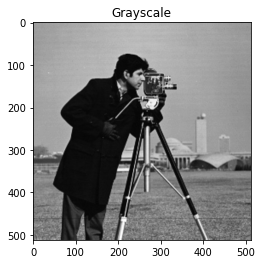

In [4]:
img = cv2.imread('./img1.jpg', cv2.IMREAD_GRAYSCALE)
print(img)
plot_output(img, 'Grayscale')

## Keras approach

In [5]:
from skimage.exposure import rescale_intensity
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
approach = 'Keras'

In [6]:
def convolve_keras(x, kernel):
    kernel = kernel.reshape((1, 3, 3, 1, 1))

    h = x.shape[0]
    w = x.shape[1]

    img = x.reshape((h, w, -1))
    batch = x.reshape(1, *x.shape)

    conv = Conv2D(
        name='conv',
        input_shape=img.shape,
        filters=1,
        kernel_size=(3, 3),
        use_bias=False,
        trainable=False,
        padding='same',
    )

    model = Sequential([conv])

    conv.set_weights(kernel)

    y = model.predict(x=batch)
    y = y[0].reshape((h, w))

    y = rescale_intensity(y, in_range=(0, 255))
    y = (y * 255).astype("uint8")

    return y

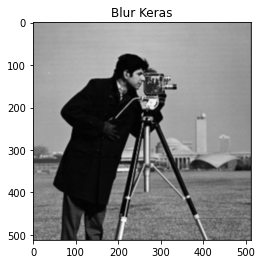

In [7]:
i = 0

name = kernels[i]['name']
name = f'{name} {approach}'
k = kernels[i]['k']

out = convolve_keras(img, k)
plot_output(out, name)

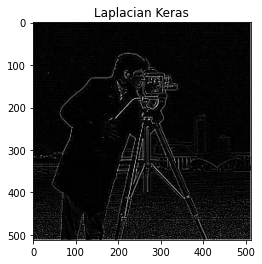

In [8]:
i = 1

name = kernels[i]['name']
name = f'{name} {approach}'
k = kernels[i]['k']

out = convolve_keras(img, k)
plot_output(out, name)

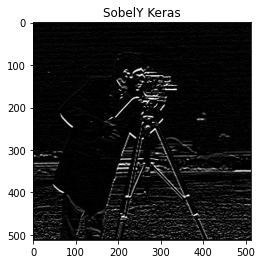

In [9]:
i = 2

name = kernels[i]['name']
name = f'{name} {approach}'
k = kernels[i]['k']

out = convolve_keras(img, k)
plot_output(out, name)

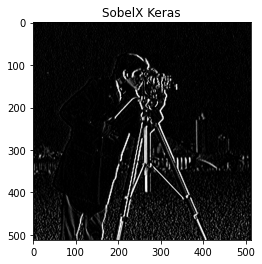

In [10]:
i = 3

name = kernels[i]['name']
name = f'{name} {approach}'
k = kernels[i]['k']

out = convolve_keras(img, k)
plot_output(out, name)

## OpenCV approach

In [11]:
approach = 'CV'

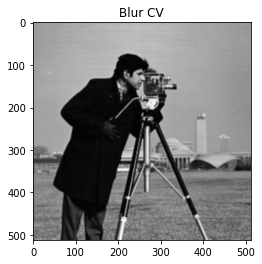

In [12]:
i = 0

name = kernels[i]['name']
name = f'{name} {approach}'
k = kernels[i]['k']

out = cv2.filter2D(img, -1, k)
plot_output(out, name)

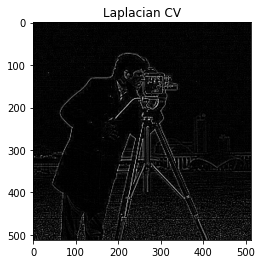

In [13]:
i = 1

name = kernels[i]['name']
name = f'{name} {approach}'
k = kernels[i]['k']

out = cv2.filter2D(img, -1, k)
plot_output(out, name)

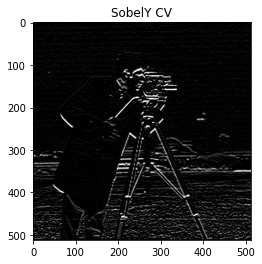

In [14]:
i = 2

name = kernels[i]['name']
name = f'{name} {approach}'
k = kernels[i]['k']

out = cv2.filter2D(img, -1, k)
plot_output(out, name)

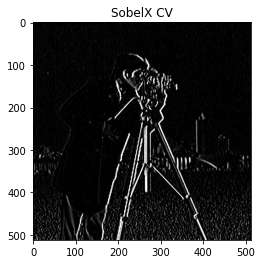

In [15]:
i = 3

name = kernels[i]['name']
name = f'{name} {approach}'
k = kernels[i]['k']

out = cv2.filter2D(img, -1, k)
plot_output(out, name)

# Q3

In [16]:
!pip install keras_tuner -q

     |████████████████████████████████| 98 kB 3.5 MB/s 


In [17]:
from tensorflow.keras.datasets.cifar10 import load_data
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt

In [18]:
(x_train, y_train), (x_test, y_test) = load_data()
x_train = x_train / 255.0
y_train = to_categorical(y_train, 10)
x_test = x_test / 255.0
y_test = to_categorical(y_test, 10)

170508288/170498071 [==============================] - 3s 0us/step


In [19]:
HEIGHT = x_train.shape[1]
WIDTH = x_train.shape[2]
CHANNELS = x_train.shape[3]
CLASSES = y_test.shape[1]

In [20]:
def build_model(hp):
    input_layer = Input(
        shape=(HEIGHT, WIDTH, CHANNELS),
    )

    x = input_layer

    conv_layers = hp.Int(
        name='conv_layers',
        min_value=1,
        max_value=3,
        step=1,
    )

    f = hp.Int(
            name='filters', 
            min_value=8,
            max_value=32,
            step=8,
    )

    r = 0.1

    for i in range(conv_layers):
        f *= 2
        r += 0.1

        x = Conv2D(
            filters=f,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            activation='relu',
        )(x)

        x = Conv2D(
            filters=f,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            activation='relu',
        )(x)

        x = MaxPool2D(pool_size=(2, 2))(x)
        x = Dropout(r)(x)

    x = Flatten()(x)

    dense_layers = hp.Int(
        name='dense_layers',
        min_value=1,
        max_value=4,
        step=1,
    )

    u = hp.Int(
        name='units', 
        min_value=128,
        max_value=256,
        step=64,
    )

    for i in range(dense_layers):
        x = Dense(
            units=u,
            activation='relu',
        )(x)

        x = Dropout(rate=0.5)(x)

    output_layer = Dense(
        units=CLASSES,
        activation='softmax',
    )(x)

    model = Model(inputs=input_layer, outputs=output_layer)

    lr = hp.Choice(
        name='lr',
        values=[0.0001, 0.0005, 0.001]
    )

    opt = hp.Choice(name='optimizer', values=['adam', 'sgd'])
    if opt == 'adam':
        optimizer = Adam(learning_rate=lr)
    elif opt == 'sgd':
        optimizer = SGD(learning_rate=lr)
    else:
        optimizer = None

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )

    return model

In [21]:
MAX_EPOCHS = 10
EPOCHS = 50
BATCH_SIZE = 64

In [22]:
tuner = kt.Hyperband(
    hypermodel=build_model,
    max_epochs=MAX_EPOCHS,
    hyperband_iterations=1,
    factor=3,
    directory='./Q3_Models',
    objective='val_accuracy',
)

In [23]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 32, 'step': 8, 'sampling': None}
dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 256, 'step': 64, 'sampling': None}
lr (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 0.0005, 0.001], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}


In [24]:
tuner.search(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
)

Trial 30 Complete [00h 03m 23s]
val_accuracy: 0.25049999356269836

Best val_accuracy So Far: 0.7250000238418579
Total elapsed time: 00h 34m 13s
INFO:tensorflow:Oracle triggered exit


In [25]:
tuner.results_summary()

Results summary
Results in ./Q3_Models/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
conv_layers: 2
filters: 16
dense_layers: 3
units: 192
lr: 0.001
optimizer: adam
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7250000238418579
Trial summary
Hyperparameters:
conv_layers: 2
filters: 16
dense_layers: 2
units: 192
lr: 0.001
optimizer: adam
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 190e537282f0d80648d0ab4fe0e78879
Score: 0.7148000001907349
Trial summary
Hyperparameters:
conv_layers: 1
filters: 24
dense_layers: 1
units: 256
lr: 0.001
optimizer: adam
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 2b437527cf02babb73f617ae69218328
Score: 0.6937000155448914
Trial summary
Hyperparameters:
conv_layers: 1
filters: 16
dense_layers: 3
units: 256
lr: 0.001
optimizer: adam
tuner/epochs: 10
tuner/initial_epoch:

In [26]:
best_hp = tuner.get_best_hyperparameters(2)[0]
best_model = build_model(best_hp)
best_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        18496     
                                                           

In [27]:
checkpoint = ModelCheckpoint(
    filepath='./checkpoints/evaluater.hdf5',
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
)

best_model.fit(
    x=x_train,
    y=y_train,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

Epoch 1/50
625/625 [==============================] - 13s 20ms/step - loss: 1.9625 - accuracy: 0.2501 - val_loss: 1.6249 - val_accuracy: 0.3780
Epoch 2/50
625/625 [==============================] - 12s 19ms/step - loss: 1.5534 - accuracy: 0.4232 - val_loss: 1.3070 - val_accuracy: 0.5252
Epoch 3/50
625/625 [==============================] - 12s 19ms/step - loss: 1.3687 - accuracy: 0.5071 - val_loss: 1.1832 - val_accuracy: 0.5705
Epoch 4/50
625/625 [==============================] - 12s 19ms/step - loss: 1.2487 - accuracy: 0.5550 - val_loss: 1.0629 - val_accuracy: 0.6257
Epoch 5/50
625/625 [==============================] - 12s 20ms/step - loss: 1.1660 - accuracy: 0.5913 - val_loss: 0.9854 - val_accuracy: 0.6462
Epoch 6/50
625/625 [==============================] - 12s 19ms/step - loss: 1.0998 - accuracy: 0.6161 - val_loss: 0.9487 - val_accuracy: 0.6714
Epoch 7/50
625/625 [==============================] - 12s 19ms/step - loss: 1.0475 - accuracy: 0.6389 - val_loss: 0.8982 - val_accuracy:

In [28]:
evaluater = load_model('./checkpoints/evaluater.hdf5')

In [29]:
evaluater.evaluate(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE,
)

782/782 [==============================] - 7s 8ms/step - loss: 0.3502 - accuracy: 0.8951


[0.35016828775405884, 0.8950799703598022]

In [30]:
evaluater.evaluate(
    x=x_test,
    y=y_test,
    batch_size=BATCH_SIZE,
)

157/157 [==============================] - 1s 8ms/step - loss: 0.6754 - accuracy: 0.7775


[0.6754277348518372, 0.7774999737739563]

# Q4

In [31]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import LocallyConnected2D
from tensorflow.keras.layers import Flatten, Dense
input_shape = (28, 28, 1)

In [32]:
model = Sequential([
    Conv2D(20, (7, 7), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(10, (5, 5), activation='relu'),
    LocallyConnected2D(2, (3, 3), activation='relu'),
    Flatten(),
    Dense(10, activation='softmax'),
])

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 22, 22, 20)        1000      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 11, 20)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 10)          5010      
                                                                 
 locally_connected2d (Locall  (None, 5, 5, 2)          4550      
 yConnected2D)                                                   
                                                                 
 flatten_2 (Flatten)         (None, 50)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                5